In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from genome.read_fasta import seq_iter
from stream.sketch import CountMinMemory
from Angus.approximation import distfinder, err_distfinder

Cannot use compiled code


In [26]:
def minim(lst):
    a = np.inf
    for pos, i in enumerate(lst):
        if i < a:
            a = i
        else:
            return pos
    return np.inf

def maxim(lst):
    a = np.inf
    min_found = False
    for pos, i in enumerate(lst):
        if i < a:
            if min_found and i > 1000:
                return pos
            else:
                a = i
        else:
            min_found = True
            a = i
    return 1
        
def error_free(lst):
    val = minim(lst)
    return lst[val:]

def error_rate(lst):
    val = minim(lst)
    num_error, num_correct = 0, 0
    for pos, i in enumerate(lst):
        if pos > val:
            num_correct += i[0]*i[1]
        else:
            num_error += i[0]*i[1]
    return num_error/(num_error + num_correct)

def num_kmers(lst):
    val = minim(lst)
    kmers = 0
    for pos, i in enumerate(lst):
        if pos > val:
            kmers += i
    return kmers

In [3]:
def read_some_data(amount, size, sketch, reads, klen):
    acc = 0
    for i in reads:
        acc += 1
        size += 80
        for j in range(80):
            kmer = i[j : j + klen]
            sketch.update(kmer)
        if acc >= amount:
            break
    return size, sketch

In [4]:
reads = seq_iter('genome/reads-aunt_01.fa.gz')
klen = 21
sketch = CountMinMemory()
amount, sketch = read_some_data(60000, 0, sketch, reads, klen)

In [5]:
data = sketch.get_feat()
counts = [x for x in enumerate(np.bincount(data))]

In [6]:
print(error_rate(counts))

0.00161229166667


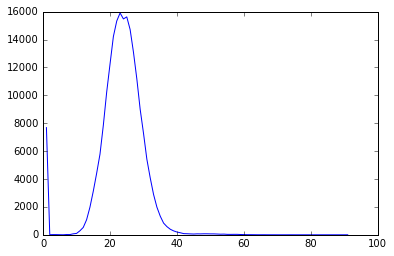

In [7]:
x = [i[0] for i in counts]
y = [i[1] for i in counts]
plt.plot(x[1:], y[1:])
    
plt.show()

In [8]:
num_kmers(counts)

198724

In [27]:
reads = seq_iter('genome/reads-aunt_01.fa.gz')
klen = 21
sketch = CountMinMemory()
amount = 0
num_kmer = []
num_kmer_filtered = []

In [28]:
# A Naive Estimate
for i in range(20):
    amount, sketch = read_some_data(5000, amount, sketch, reads, klen)
    data = sketch.get_feat()
    counts = [x for x in np.bincount(data)]
    num_kmer.append(sum(x for x in counts[1:]))
    num_kmer_filtered.append(num_kmers(counts))

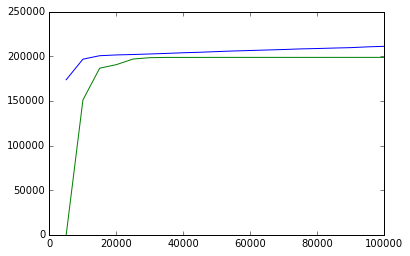

In [29]:
x = [5000*i for i in range(1, 21)]
plt.plot(x, num_kmer, x, num_kmer_filtered)
    
plt.show()

In [12]:
reads = seq_iter('genome/reads-aunt_00.fa.gz')
klen = 21
sketch = CountMinMemory()
amount = 0

amount, sketch = read_some_data(2*12500, amount, sketch, reads, klen)

In [13]:
counts = [x for x in np.bincount(sketch.get_feat())]
print(counts)

[16574955, 3616, 422, 1242, 3528, 7394, 12486, 18400, 23432, 24480, 24254, 22972, 18305, 14103, 10078, 6808, 4427, 2721, 1491, 871, 448, 220, 157, 112, 89, 72, 32, 29, 21, 21, 12, 3, 6, 3, 1, 2, 1, 0, 0, 1, 1]


In [14]:
print(sum(x*y for x, y in enumerate(counts)))
print(sum(counts[1:]))

2000000
202261


In [15]:
# Attempting a 2 step-optimisation.
def estimate(counts, err_guess, genome_guess, maximum):
    
    reads = sum(x*y for x, y in enumerate(counts))
    freq_freq = err_distfinder(genome_guess, reads, maximum, err_guess)

    acc = 0
    switch = False

    while acc < 30:
        lr = 1/(1 + (acc >> 3))
        if switch:
#             print(err_rate, lr, counts[1], freq_freq[1])
            err_guess *= (counts[1]/freq_freq[1])**lr
            freq_freq = err_distfinder(genome_guess, reads, maximum, err_guess)
            switch = False
        else:
            max_freq, max_counts = maxim(freq_freq), maxim(counts)
#             print(genome_size, lr, freq_freq[max_freq], counts[max_counts])
#             print((counts[max_counts], freq_freq[max_freq]))
            genome_guess = int(genome_guess * ((counts[max_counts]/freq_freq[max_freq]))**lr)
#             print(genome_guess, reads, maximum, err_guess)
            freq_freq = err_distfinder(genome_guess, reads, maximum, err_guess)
            switch = True
        acc += 1
    return (err_guess, genome_guess, freq_freq)

In [16]:
reads = seq_iter('genome/reads-aunt_00.fa.gz')
klen = 21
sketch = CountMinMemory()
amount = 0

amount, sketch = read_some_data(2*1250, amount, sketch, reads, klen)

counts1 = [x for x in np.bincount(sketch.get_feat())]

amount, sketch = read_some_data(2*(3750 - 1250), amount, sketch, reads, klen)

counts2 = [x for x in np.bincount(sketch.get_feat())]

amount, sketch = read_some_data(2*(6500 - 3750), amount, sketch, reads, klen)

counts3 = [x for x in np.bincount(sketch.get_feat())]

amount, sketch = read_some_data(2*(12500 - 6500), amount, sketch, reads, klen)

counts4 = [x for x in np.bincount(sketch.get_feat())]

amount, sketch = read_some_data(2*(18750 - 12500), amount, sketch, reads, klen)

counts5 = [x for x in np.bincount(sketch.get_feat())]

amount, sketch = read_some_data(2*(31250 - 18750), amount, sketch, reads, klen)

counts6 = [x for x in np.bincount(sketch.get_feat())]


In [17]:
err_rate1, genome_size1, freq_freq1 = estimate(counts1, 1/100, 150000, 20)
err_rate2, genome_size2, freq_freq2 = estimate(counts2, 1/100, 150000, 30)
err_rate3, genome_size3, freq_freq3 = estimate(counts3, 1/100, 150000, 40)
err_rate4, genome_size4, freq_freq4 = estimate(counts4, 1/100, 150000, 60)
err_rate5, genome_size5, freq_freq5 = estimate(counts5, 1/100, 150000, 80)
err_rate6, genome_size6, freq_freq6 = estimate(counts6, 1/100, 150000, 100)

In [18]:
print(err_rate1, err_rate2, err_rate3, err_rate4, err_rate5, err_rate6)
print(genome_size1, genome_size2, genome_size3, genome_size4, genome_size5, genome_size6)

0.0096788041177 0.0138627530747 0.0026217856177 0.00176005127374 0.00175969152698 0.001708564321
190427 182189 190546 202086 199948 193057


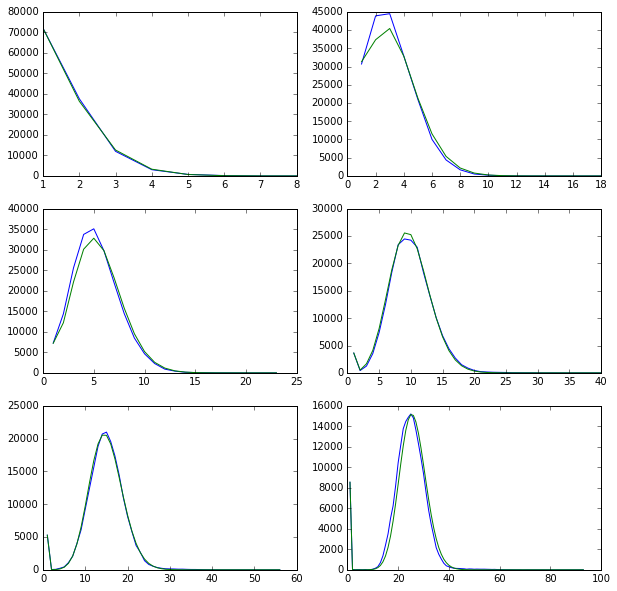

In [19]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10))

x = [i for i in range(1, len(counts1))]
axes[0][0].plot(x, counts1[1:], x, freq_freq1[1:len(counts1)])

x = [i for i in range(1, len(counts2))]
axes[0][1].plot(x, counts2[1:], x, freq_freq2[1:len(counts2)])

x = [i for i in range(1, len(counts3))]
axes[1][0].plot(x, counts3[1:], x, freq_freq3[1:len(counts3)])

x = [i for i in range(1, len(counts4))]
axes[1][1].plot(x, counts4[1:], x, freq_freq4[1:len(counts4)])

x = [i for i in range(1, len(counts5))]
axes[2][0].plot(x, counts5[1:], x, freq_freq5[1:len(counts5)])

x = [i for i in range(1, len(counts6))]
axes[2][1].plot(x, counts6[1:], x, freq_freq6[1:len(counts6)])

plt.show()

In [21]:
# Attempting a 2 step-optimisation.
def second_estimate(counts):
    
    minimum = minim(counts)
    
    reads = sum(x*y for x, y in enumerate(counts))
    
    if minimum == np.inf:
        genome_guess = sum(counts)
        err_guess = 1/100
    else:
        genome_guess = sum(counts[minim(counts):])
        err_guess = 1 - (sum(x*y for x, y in enumerate(counts) if x > minimum)/reads)
    
    freq_freq = err_distfinder(genome_guess, reads, 50, err_guess)

    acc = 0
    switch = False

    while acc < 30:
        lr = 1/(1 + (acc >> 3))
        if switch:
#             print(err_rate, lr, counts[1], freq_freq[1])
            err_guess *= ((counts[1]/freq_freq[1])*((counts[2]/freq_freq[2])**(1/2)))**lr
            freq_freq = err_distfinder(genome_guess, reads, 50, err_guess)
            switch = False
        else:
            max_freq, max_counts = maxim(freq_freq), maxim(counts)
#             print(genome_size, lr, freq_freq[max_freq], counts[max_counts])
#             print((counts[max_counts], freq_freq[max_freq]))
            if max_counts > 1 and max_freq > 1:
                guess_coeff = ((counts[max_counts]/freq_freq[max_freq])*
                               (((counts[max_counts - 1]/freq_freq[max_freq - 1])*
                                 (counts[max_counts + 1]/freq_freq[max_freq + 1]))**(1/2)))**lr
            else:
                guess_coeff = ((counts[max_counts]/freq_freq[max_freq])*
                               ((counts[max_counts + 1]/freq_freq[max_freq + 1])**(1/2)))**lr
                
            genome_guess = int(genome_guess * ((counts[max_counts]/freq_freq[max_freq]))**lr)
#             print(genome_guess, reads, maximum, err_guess)
            freq_freq = err_distfinder(genome_guess, reads, 50, err_guess)
            switch = True
        acc += 1
    return (err_guess, genome_guess, freq_freq)

In [30]:
b_err_rate1, b_genome_size1, b_freq_freq1 = second_estimate(counts1)
b_err_rate2, b_genome_size2, b_freq_freq2 = second_estimate(counts2)
b_err_rate3, b_genome_size3, b_freq_freq3 = second_estimate(counts3)
b_err_rate4, b_genome_size4, b_freq_freq4 = second_estimate(counts4)
b_err_rate5, b_genome_size5, b_freq_freq5 = second_estimate(counts5)
b_err_rate6, b_genome_size6, b_freq_freq6 = second_estimate(counts6)

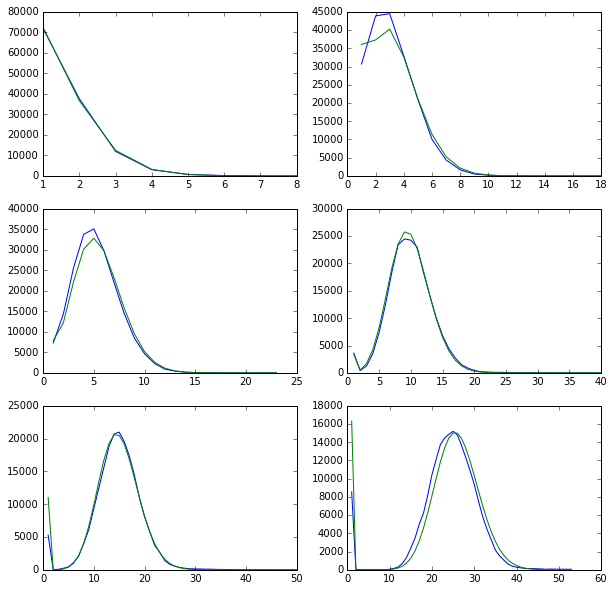

In [41]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 10))

x = [i for i in range(1, len(counts1))]
axes[0][0].plot(x, counts1[1:], x, b_freq_freq1[1:len(counts1)])

x = [i for i in range(1, len(counts2))]
axes[0][1].plot(x, counts2[1:], x, b_freq_freq2[1:len(counts2)])

x = [i for i in range(1, len(counts3))]
axes[1][0].plot(x, counts3[1:], x, b_freq_freq3[1:len(counts3)])

x = [i for i in range(1, len(counts4))]
axes[1][1].plot(x, counts4[1:], x, b_freq_freq4[1:len(counts4)])

x = [i for i in range(1, min(len(counts5), len(b_freq_freq5)))]
axes[2][0].plot(x, counts5[1:min(len(counts5), len(b_freq_freq5))], x, b_freq_freq5[1:min(len(counts5), len(b_freq_freq5))])

x = [i for i in range(1, min(len(counts6), len(b_freq_freq6)))]
axes[2][1].plot(x, counts6[1:min(len(counts6), len(b_freq_freq6))], x, b_freq_freq6[1:min(len(counts6), len(b_freq_freq6))])

plt.show()

In [38]:
print(b_freq_freq5, counts5)

[12587271    11024       11       35      134      400      998     2133
     3985     6619     9893    13444    16745    19254    20556    20484
    19136    16825    13972    10992     8214     5847     3972     2581
     1607      961      552      305      163       84       41       20
        9        4        1        0        0        0        0        0
        0        0        0        0        0        0        0        0
        0        0        0] [16573186, 5278, 46, 70, 233, 441, 1090, 2060, 3988, 6106, 9308, 12490, 15633, 18805, 20682, 20973, 19536, 17343, 14432, 10941, 8096, 5852, 3707, 2675, 1390, 817, 547, 344, 234, 153, 136, 124, 95, 98, 70, 53, 51, 38, 24, 17, 17, 12, 5, 5, 3, 2, 3, 1, 2, 2, 1, 0, 0, 0, 0, 0, 1]
